In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
import requests
import sys
import os

In [13]:
# Parameters
tickers = ['JNJ', 'NVDA', 'META', 'GOOGL']
sequence_length = 30
batch_size = 64
hidden_size = 50
num_epochs = 10
learning_rate = 0.001

# Download stock data
def get_stock_data(ticker):
    df = yf.download(ticker, start="2015-01-01", end="2023-12-31")
    return df[['Close']]

data = pd.concat([get_stock_data(t) for t in tickers], axis=1)
data.columns = tickers
data.dropna(inplace=True)

# Normalize
scalers = {}
scaled_data = pd.DataFrame()
for ticker in tickers:
    scaler = MinMaxScaler()
    scaled_data[ticker] = scaler.fit_transform(data[[ticker]]).flatten()
    scalers[ticker] = scaler

# Dataset
class StockDataset(Dataset):
    def __init__(self, series, seq_len):
        self.X = []
        self.y = []
        for i in range(len(series) - seq_len):
            self.X.append(series[i:i+seq_len])
            self.y.append(series[i+seq_len])
        self.X = np.array(self.X)
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Use one ticker for demonstration (e.g., AAPL)
dataset = StockDataset(scaled_data['JNJ'].values, sequence_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(-1))
        return self.fc(out[:, -1, :])

model = LSTM(input_size=1, hidden_size=hidden_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        output = model(X_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

In [ ]:
from keras.layers import LSTM, Dense
from keras.models import Sequential

batch_size = 32

print("Loading data...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

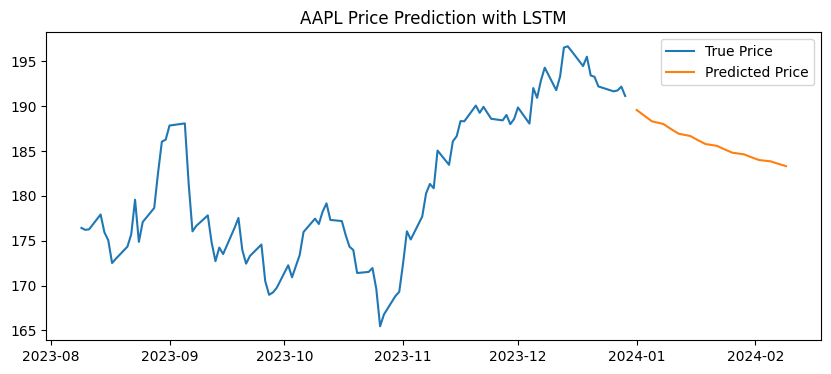

In [4]:
# Evaluate on last part of dataset
model.eval()
test_inputs = scaled_data['AAPL'].values[-sequence_length:].tolist()
predictions = []

for _ in range(30):  # predict next 30 days
    seq = torch.tensor(test_inputs[-sequence_length:], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        pred = model(seq).item()
        predictions.append(pred)
        test_inputs.append(pred)

# Inverse transform
predicted_prices = scalers['AAPL'].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 4))
plt.plot(data.index[-100:], data['AAPL'].values[-100:], label='True Price')
future_index = pd.date_range(start=data.index[-1], periods=31, freq='B')[1:]
plt.plot(future_index, predicted_prices, label='Predicted Price')
plt.legend()
plt.title('AAPL Price Prediction with LSTM')
plt.show()

In [ ]:
from helpers.windowshap import StationaryWindowSHAP
import pickle 

# Load your trained LSTM model (torch model)
# Example: if you saved it with torch.save
model = torch.load('lstm_model.pth')
model.eval()

# Load or reconstruct your input data sequences
# Assuming you have them saved or recreate from your notebook's saved scalers/data
with open('X_tensor.pkl', 'rb') as f:
    X_tensor = pickle.load(f)  # shape: [num_samples, seq_len, features]

# Make sure to keep data as float32 torch tensor
X_tensor = X_tensor.float()

# Define a prediction function that WindowSHAP will call
def model_predict(x_np):
    """
    Input: x_np - numpy array of shape (batch_size, seq_len, features)
    Output: numpy array of predictions
    """
    with torch.no_grad():
        x_tensor = torch.tensor(x_np, dtype=torch.float32)
        preds = model(x_tensor).squeeze().numpy()
    return preds

# Parameters
window_size = 10  # or whatever makes sense for your sequences

# Initialize WindowSHAP
ws = StationaryWindowSHAP(
    model=model_predict,
    input_data=X_tensor.numpy(),  # numpy array
    baseline=None,  # Optional: you can provide baseline if you want
    window_size=window_size,
    num_samples=1000,  # number of perturbation samples for SHAP
    task="regression"  # since you are predicting prices
)

# Compute SHAP values
shap_values = ws.shap_values()  # This will be numpy array of SHAP values

# Save SHAP values for later visualization
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

ModuleNotFoundError: No module named 'helpers'